The object here is to train a machine learning model on a database of Tweets and use that model to predict sentiment of Tweets from a user, a hashtag, or any random variety of Tweets. 

**@author Ryan Herren**

**@author Tanner Dunn**

The following link is a good informational guide on how to roughly implement a model like we are aiming for. https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

# Initialize environment, install packages

In [72]:
import tweepy
import pandas as pd
import numpy as np
import operator 
import json
from collections import Counter
import os
import yaml
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import math
import time
from tqdm import tqdm
import seaborn as sns
import random
pd.set_option('display.max_colwidth', None)
import ipywidgets as widgets

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanherren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.environ['python-bot-config'] = "/Users/ryanherren/python-bot-config.yaml"
# os.environ['python-bot-config'] = "/Users/dunnt/python-bot-config.yaml"

In [3]:
try:
    v_env = os.environ['python-bot-config']
except:
    print("Config file env variable is not set.")
    print("Set python-bot-config file")
    sys.exit(1)

with open(v_env, "r") as yamlConfig:
    cfg = yaml.safe_load(yamlConfig)

# Import Opinion Lexicon

In [4]:
# Reading negative words list:
with open('negative-words.txt', 'r', encoding = "ISO-8859-1") as t:
    neg = t.readlines()
    neg_words = []
    for i in neg:
        neg_words.append(i.strip())
    del neg_words[0 : 31]
    

# Reading positive words list:
with open('positive-words.txt', 'r', encoding = "ISO-8859-1") as t:
    pos = t.readlines()
    pos_words = []
    for i in pos:
        pos_words.append(i.strip())
    del pos_words[0 : 30]
    
positive_emojis = ['😂','🔥','😍','🤘','🤩','👍','💯','😎','✅','👏','😀','🐐',
                   '❤️','♥️','😘','😊','😄','😃','😆','😋','🤪','😜','😛','🤑']
negative_emojis = ['🥴','🤢','🤮','😧','😑','😰','🤬','😡','😭','😢','😩','🙁',
                   '☹️','😣','😖','😫','😟','😞','😔','😒','👿','🤕','🤒','😷']

# Function to count sentiment words in Tweets

In [5]:
# Function to count negative words in tweet:
def count_negative(tweet):
    neg_word_count = 0
    for word in tweet:
        if word.lower() in neg_words:
            neg_word_count = neg_word_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return neg_word_count
   
# Function to count positive words in tweet:
def count_positive(tweet):
    pos_word_count = 0
    for word in tweet:
        #print(word)
        if word.lower() in pos_words:
            pos_word_count = pos_word_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return pos_word_count
   
def count_mentions(tweet):
    num_mentions = 0
    for word in tweet:
        if word.startswith('@'):
            num_mentions = num_mentions + 1
    return num_mentions

def count_hashtags(tweet):
    num_hashtags = 0
    for word in tweet:
        if word.startswith('#'):
            num_hashtags = num_hashtags + 1
    return num_hashtags

def count_positive_emojis(tweet):
    pos_emoji_count = 0
    for word in tweet:
        #print(word)
        if word in positive_emojis:
            pos_emoji_count = pos_emoji_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return pos_emoji_count

def count_negative_emojis(tweet):
    neg_emoji_count = 0
    for word in tweet:
        #print(word)
        if word in negative_emojis:
            neg_emoji_count = neg_emoji_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return neg_emoji_count

# Tokenizing functions to break tweets into words, emojis, mentions, and hashtags

In [6]:
# This cell is the basis of how tokenizing the Tweet will work. Using regex statments, it accounts for emojis, 
# hashtags, mentions, and more.
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

# Configure Twitter API Connection

In [7]:
consumer_key = cfg.get("TwitterAPI").get("consumer_key")
consumer_secret = cfg.get("TwitterAPI").get("consumer_secret")
access_token = cfg.get("TwitterAPI").get("access_token")
access_token_secret = cfg.get("TwitterAPI").get("access_token_secret")

In [8]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

# Get Tweets by User

In [122]:
# Currently limited to num_tweets Tweets
column_names = ['tweet_id', 'text','created_at']
def get_tweets_by_user(user, tweets):
    tweet_json = pd.DataFrame(columns=column_names)
    for i in range(math.ceil(tweets/20)):
        tweets = api.user_timeline(user, page=i)
#         print(str(i) + "WABBADABBADO\n")
#         print(tweets)
        my_list_of_dicts = []
        for each_json_tweet in tweets:
            my_list_of_dicts.append(each_json_tweet._json)
        filename = user + '.txt'
        if os.path.exists(filename):
            os.remove(filename)
        with open(filename, 'w') as file:
            file.write(json.dumps(my_list_of_dicts, indent=4))
        my_demo_list = []
        with open(filename, encoding='utf-8') as json_file:  
            all_data = json.load(json_file)
            for each_dictionary in all_data:
                tweet_id = each_dictionary['id']
                text = each_dictionary['text']
                favorite_count = each_dictionary['favorite_count']
                retweet_count = each_dictionary['retweet_count']
                created_at = each_dictionary['created_at']
                my_demo_list.append({'tweet_id': str(tweet_id),
                                     'text': str(text),
                                     'created_at': created_at,
                                    })
                #print(my_demo_list)
                temp_json = pd.DataFrame(my_demo_list, columns = 
                                          ['tweet_id', 'text', 
                                           'created_at'])
#             print("\n \n " + str(temp_json.shape) + str(type(temp_json)) + "\n\n")
        tweet_json = tweet_json.append(temp_json, ignore_index=True)
#         print("\n \n " + str(tweet_json.shape) + str(type(tweet_json)) + "\n\n")
    tweet_json = tweet_json.drop_duplicates()    
    return tweet_json

# Get Tweets by Hashtag

In [10]:
# TODO

# Loading in Training Data from Kaggle

In [11]:
# TODO
# https://www.kaggle.com/kazanova/sentiment140
# Download this dataset (~230mb) to your project directory
# Once this is done, begin training models

# 0 is negative
# 2 is neutral
# 4 is positive

# This dataset does not have any emojis, so we will have to find an alternative way if 
# we want to evaluate the effects that emojis have on sentiment

In [19]:
training_cnames = ['sentiment', 'tweet_id', 'created_at', 'mention', 'author', 'text']

training_data_full = pd.read_csv('training.1600000.processed.noemoticon.csv', names = training_cnames, encoding='latin-1')

training_data_full = training_data_full[['sentiment', 'tweet_id', 'created_at', 'text']]

In [20]:
# You can use this to slim down the data set.
# Loading and manipulating the full dataset takes about 30 minutes
# Pulling in 15000 tweets takes ~18 seconds to manipulate and will give a sufficient
# training set to use
training_data = training_data_full.sample(15000)

In [21]:
start = time.time()
training_data['tokenized'] = training_data['text'].apply(lambda x: tokenize(x))
training_data['pos_words'] = training_data['tokenized'].apply(lambda x: count_positive(x))
training_data['neg_words'] = training_data['tokenized'].apply(lambda x: count_negative(x))
training_data['num_mentions'] = training_data['tokenized'].apply(lambda x: count_mentions(x))
training_data['num_hashtags'] = training_data['tokenized'].apply(lambda x: count_hashtags(x))
training_data['num_positive_emojis'] = training_data['tokenized'].apply(lambda x: count_positive_emojis(x))
training_data['num_negative_emojis'] = training_data['tokenized'].apply(lambda x: count_negative_emojis(x))
end = time.time()
print(end - start)

16.445995092391968


In [22]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
1111982,4,1972329133,Sat May 30 09:01:18 PDT 2009,@Jonnycraig4l haha your crazy!! i hope you in ...,"[@Jonnycraig4l, haha, your, crazy, !, !, i, ho...",0,1,1,0,0,0
505718,0,2188466058,Mon Jun 15 21:57:06 PDT 2009,I'm guilty 2 --&gt;T @vanessaveasley: #haveyo...,"[I'm, guilty, 2, -, -, &, gt, ;, T, @vanessave...",0,2,1,1,0,0
780343,0,2323150402,Thu Jun 25 00:00:56 PDT 2009,The first day of the holidays and I bored me a...,"[The, first, day, of, the, holidays, and, I, b...",0,1,0,0,0,0
1055161,4,1962159950,Fri May 29 10:36:57 PDT 2009,@bethh_kidd http://bit.ly/D5QzI like that ?,"[@bethh_kidd, http://bit.ly/D5QzI, like, that, ?]",1,0,1,0,0,0
510541,0,2189678375,Tue Jun 16 00:37:28 PDT 2009,nooooooooooo! temptation is leaving ! bummer ...,"[nooooooooooo, !, temptation, is, leaving, !, ...",0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
707931,0,2257146005,Sat Jun 20 13:52:11 PDT 2009,@_rachaelll fiona cause she abused me for t...,"[@_rachaelll, fiona, cause, she, abused, me, f...",0,1,1,0,0,0
1352818,4,2046590173,Fri Jun 05 12:24:13 PDT 2009,@delanie_ we can do that when he have him appr...,"[@delanie_, we, can, do, that, when, he, have,...",1,0,1,0,0,0
1122362,4,1974317176,Sat May 30 12:52:58 PDT 2009,"@rohitdoshi yes my friend, PLAN! But seriously...","[@rohitdoshi, yes, my, friend, ,, PLAN, !, But...",0,0,1,0,0,0
1543339,4,2181349780,Mon Jun 15 11:42:29 PDT 2009,"@Cascadia Yeah, ain't it funny when legalese i...","[@Cascadia, Yeah, ,, ain't, it, funny, when, l...",0,2,1,0,0,0


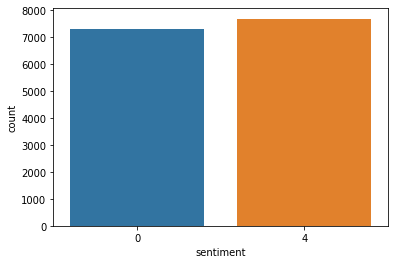

In [23]:
sns.countplot(x='sentiment', data=training_data)

# Load in Emoji Training Data from DS301 Bot Timeline

In [24]:
training_data_emojis = get_tweets_by_user('DS301Bot', 100)
training_data_emojis['tokenized'] = training_data_emojis['text'].apply(lambda x: tokenize(x))
training_data_emojis['pos_words'] = training_data_emojis['tokenized'].apply(lambda x: count_positive(x))
training_data_emojis['neg_words'] = training_data_emojis['tokenized'].apply(lambda x: count_negative(x))
training_data_emojis['num_mentions'] = training_data_emojis['tokenized'].apply(lambda x: count_mentions(x))
training_data_emojis['num_hashtags'] = training_data_emojis['tokenized'].apply(lambda x: count_hashtags(x))
training_data_emojis['num_positive_emojis'] = training_data_emojis['tokenized'].apply(lambda x: count_positive_emojis(x))
training_data_emojis['num_negative_emojis'] = training_data_emojis['tokenized'].apply(lambda x: count_negative_emojis(x))

In [25]:
training_data_emojis

,tweet_id,text,created_at,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
0,1467703601913077760,A+ on my Data Science final? Perfect. ✅,Mon Dec 06 03:53:01 +0000 2021,"[A, +, on, my, Data, Science, final, ?, Perfec...",1,0,0,0,1,0
1,1467703471000412168,I love rock n' roll 🤘,Mon Dec 06 03:52:30 +0000 2021,"[I, love, rock, n, ', roll, 🤘]",1,0,0,0,1,0
2,1467703361424216072,I am sick. COVID sucks. 😷,Mon Dec 06 03:52:04 +0000 2021,"[I, am, sick, ., COVID, sucks, ., 😷]",0,2,0,0,0,1
3,1467702988101898242,I am so pissed off that there is not any snowf...,Mon Dec 06 03:50:35 +0000 2021,"[I, am, so, pissed, off, that, there, is, not,...",0,1,0,0,0,0
4,1467702798032777218,It is cold outside and I am really mad about i...,Mon Dec 06 03:49:50 +0000 2021,"[It, is, cold, outside, and, I, am, really, ma...",1,2,0,0,0,1
5,1467702582416220163,"Breathe deep darling, you're gonna be alright....",Mon Dec 06 03:48:58 +0000 2021,"[Breathe, deep, darling, ,, you're, gonna, be,...",1,0,0,0,0,0
6,1467687257171795970,If I tell you I don't like something and you c...,Mon Dec 06 02:48:05 +0000 2021,"[If, I, tell, you, I, don't, like, something, ...",1,1,0,0,0,1
7,1467686277030064133,What a bad day. 😞,Mon Dec 06 02:44:11 +0000 2021,"[What, a, bad, day, ., 😞]",0,1,0,0,0,1
8,1467684957514567684,What a good day. 😄,Mon Dec 06 02:38:56 +0000 2021,"[What, a, good, day, ., 😄]",1,0,0,0,1,0
9,1467684474855075844,Phil Hellmuth is one of the most legendary pok...,Mon Dec 06 02:37:01 +0000 2021,"[Phil, Hellmuth, is, one, of, the, most, legen...",1,0,0,0,0,0


In [26]:
# Custom sentiment assignments for tweets with emojis
emojis_sentiment = [4,4,0,0,0,4,0,0,4,4,4,4,0,4,4,4,0,4,4,4,0,0,4,0,4,0,4,0,0,4,0,0,0,4,4,4,0,4,4]

In [27]:
training_data_emojis.insert(0, 'sentiment', emojis_sentiment)

In [28]:
training_data = training_data.append(training_data_emojis)

In [29]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
1111982,4,1972329133,Sat May 30 09:01:18 PDT 2009,@Jonnycraig4l haha your crazy!! i hope you in ...,"[@Jonnycraig4l, haha, your, crazy, !, !, i, ho...",0,1,1,0,0,0
505718,0,2188466058,Mon Jun 15 21:57:06 PDT 2009,I'm guilty 2 --&gt;T @vanessaveasley: #haveyo...,"[I'm, guilty, 2, -, -, &, gt, ;, T, @vanessave...",0,2,1,1,0,0
780343,0,2323150402,Thu Jun 25 00:00:56 PDT 2009,The first day of the holidays and I bored me a...,"[The, first, day, of, the, holidays, and, I, b...",0,1,0,0,0,0
1055161,4,1962159950,Fri May 29 10:36:57 PDT 2009,@bethh_kidd http://bit.ly/D5QzI like that ?,"[@bethh_kidd, http://bit.ly/D5QzI, like, that, ?]",1,0,1,0,0,0
510541,0,2189678375,Tue Jun 16 00:37:28 PDT 2009,nooooooooooo! temptation is leaving ! bummer ...,"[nooooooooooo, !, temptation, is, leaving, !, ...",0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
54,4,1467634159027822597,Sun Dec 05 23:17:05 +0000 2021,Ethereum is going to be the best asset on the ...,"[Ethereum, is, going, to, be, the, best, asset...",1,0,0,0,2,0
55,4,1467633730864910340,Sun Dec 05 23:15:23 +0000 2021,"Live, laugh, love ❤️","[Live, ,, laugh, ,, love, ❤, ️]",1,0,0,0,0,0
56,0,1467633636904079362,Sun Dec 05 23:15:01 +0000 2021,"Oklahoma sucks, everyone I know hates Oklahoma 👿","[Oklahoma, sucks, ,, everyone, I, know, hates,...",0,2,0,0,0,1
57,4,1467633503663656960,Sun Dec 05 23:14:29 +0000 2021,"I love Brock Purdy, he’s the best! 🐐","[I, love, Brock, Purdy, ,, he, ’, s, the, best...",2,0,0,0,1,0


In [30]:
training_data['pos_total'] = training_data['pos_words'] + training_data['num_positive_emojis']
training_data['neg_total'] = training_data['neg_words'] + training_data['num_negative_emojis']

In [31]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis,pos_total,neg_total
1111982,4,1972329133,Sat May 30 09:01:18 PDT 2009,@Jonnycraig4l haha your crazy!! i hope you in ...,"[@Jonnycraig4l, haha, your, crazy, !, !, i, ho...",0,1,1,0,0,0,0,1
505718,0,2188466058,Mon Jun 15 21:57:06 PDT 2009,I'm guilty 2 --&gt;T @vanessaveasley: #haveyo...,"[I'm, guilty, 2, -, -, &, gt, ;, T, @vanessave...",0,2,1,1,0,0,0,2
780343,0,2323150402,Thu Jun 25 00:00:56 PDT 2009,The first day of the holidays and I bored me a...,"[The, first, day, of, the, holidays, and, I, b...",0,1,0,0,0,0,0,1
1055161,4,1962159950,Fri May 29 10:36:57 PDT 2009,@bethh_kidd http://bit.ly/D5QzI like that ?,"[@bethh_kidd, http://bit.ly/D5QzI, like, that, ?]",1,0,1,0,0,0,1,0
510541,0,2189678375,Tue Jun 16 00:37:28 PDT 2009,nooooooooooo! temptation is leaving ! bummer ...,"[nooooooooooo, !, temptation, is, leaving, !, ...",0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,4,1467634159027822597,Sun Dec 05 23:17:05 +0000 2021,Ethereum is going to be the best asset on the ...,"[Ethereum, is, going, to, be, the, best, asset...",1,0,0,0,2,0,3,0
55,4,1467633730864910340,Sun Dec 05 23:15:23 +0000 2021,"Live, laugh, love ❤️","[Live, ,, laugh, ,, love, ❤, ️]",1,0,0,0,0,0,1,0
56,0,1467633636904079362,Sun Dec 05 23:15:01 +0000 2021,"Oklahoma sucks, everyone I know hates Oklahoma 👿","[Oklahoma, sucks, ,, everyone, I, know, hates,...",0,2,0,0,0,1,0,3
57,4,1467633503663656960,Sun Dec 05 23:14:29 +0000 2021,"I love Brock Purdy, he’s the best! 🐐","[I, love, Brock, Purdy, ,, he, ’, s, the, best...",2,0,0,0,1,0,3,0


In [32]:
def standardize_sentiment(x, y):
#     print(row['pos_total'])
    if x > y:
        ret = 'positive'
    elif x < y:
        ret = 'negative'
    elif x == y:
        rando = random.randint(0, 1)
        if rando == 1:
            ret = 'negative'
        else:
            ret = 'positive'
    return ret

In [33]:
sentiment1 = []
for index, row in training_data.iterrows():
    x = row['pos_total']
    y = row['neg_total']
    sentiment1.append(standardize_sentiment(x, y))

In [34]:
training_data = training_data.drop(columns='sentiment')
training_data.insert(0, 'sentiment', sentiment1)

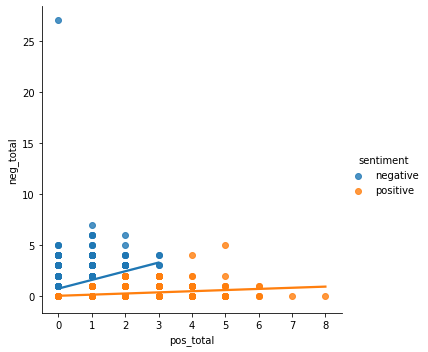

In [35]:
sns.lmplot('pos_total', 'neg_total', data = training_data, hue = 'sentiment')

# Train ML Models on Training Data

In [36]:
# SVM

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics

In [38]:
svm_X = training_data[['pos_total', 'neg_total']].to_numpy()
# svm_X = training_data[['pos_words', 'neg_words', 'num_positive_emojis', 'num_negative_emojis']].to_numpy()
svm_y = training_data[['sentiment']].to_numpy()

In [39]:
x_train, x_test, y_train, y_test = train_test_split(svm_X, svm_y)
model = SVC(kernel= 'linear').fit(x_train, y_train)

/Users/ryanherren/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
accuracy = model.score(x_test,y_test)
accuracy

0.7909574468085107

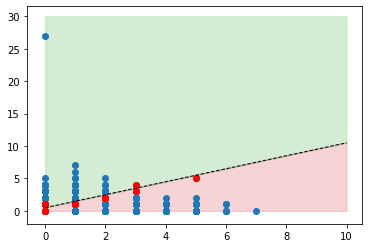

In [52]:
import matplotlib.pyplot as plt
support_vectors = model.support_vectors_

b = model.intercept_[0]
w1, w2 = model.coef_.T
c= -b/w2
m = -w1/w2
xmin, xmax = 0, 10.0
ymin, ymax = 0, 30
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color = 'tab:red', alpha = .2)
plt.fill_between(xd, yd, ymax, color='tab:green', alpha = .2)

plt.scatter(x_train[:,0], x_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color = 'red')
plt.show()

# Running Model on Entered User

In [42]:
# user_tweets = get_tweets_by_user('CycloneLarry69', 109)

In [97]:
def evaluate_tweets(user_tweets):
    user_tweets['tokenized'] = user_tweets['text'].apply(lambda x: tokenize(x))
    user_tweets['pos_words'] = user_tweets['tokenized'].apply(lambda x: count_positive(x))
    user_tweets['neg_words'] = user_tweets['tokenized'].apply(lambda x: count_negative(x))
    user_tweets['num_mentions'] = user_tweets['tokenized'].apply(lambda x: count_mentions(x))
    user_tweets['num_hashtags'] = user_tweets['tokenized'].apply(lambda x: count_hashtags(x))
    user_tweets['num_positive_emojis'] = user_tweets['tokenized'].apply(lambda x: count_positive_emojis(x))
    user_tweets['num_negative_emojis'] = user_tweets['tokenized'].apply(lambda x: count_negative_emojis(x))
    user_tweets['pos_total'] = user_tweets['pos_words'] + user_tweets['num_positive_emojis']
    user_tweets['neg_total'] = user_tweets['neg_words'] + user_tweets['num_negative_emojis']
    x_pred = user_tweets[['pos_total', 'neg_total']].to_numpy()
    y_pred = model.predict(x_pred)
    user_tweets.insert(0, 'sentiment', y_pred)
    return user_tweets

# Enter a Twitter Username in the dialogue box below

In [129]:
username = widgets.Text()
input_text = widgets.Text()

def bind_input_to_output(sender):
    username.value = input_text.value
    print('Username submitted')

input_text.on_submit(bind_input_to_output)

input_text

Text(value='')

Username submitted
Username submitted
Username submitted
Username submitted


# Once you've entered a username, run this cell to see the sentiment analysis

In [132]:
user_tweets = get_tweets_by_user(username.value, 100)
evaluate_tweets(user_tweets)
out = widgets.Output(layout={'border': '1px solid black'})
with out:
    for index, row in user_tweets.iterrows():
        print('\n' + row['text'] + '\n')
        print(row['sentiment'] + '\n')
        print('__________________________________________________________________________________________________________')
out

Output(layout=Layout(border='1px solid black'))

In [62]:
# punctuation = list(string.punctuation)
# stop = stopwords.words('english') + punctuation + ['rt', 'via', '’', 'RT', '️', '…']

In [63]:
# count_all = Counter()
# for tweet in user_tweets['text']:
#     terms_all = [term for term in preprocess(tweet)]
#     terms_stop = [term for term in preprocess(tweet) if term not in stop]
#     count_all.update(terms_stop)
#     print(tweet + "\n")
# print(count_all.most_common(10))